This jupyter notebook is here to test properties of the training set (positive-defineteness, symmetry, etc)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
from os.path import exists
import scipy.linalg as linalg
import numpy as np
import george # <- I love this name
from IPython.utils import io
import time, math, sys, os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'

sys.path.insert(1, '/home/joeadamo//Research')
from CovNet import CovNet, CovaPT

<Figure size 432x288 with 0 Axes>

In [19]:
train_nuisance = False
train_cholesky = True
N = 110093
#N = 52500
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-HighZ-NGC/"
save_dir = "/home/joeadamo/Research/CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [4]:
def chi_squared(C, x):
    P = np.linalg.inv(C)
    return np.matmul(x.T, np.matmul(P, x))

In [5]:
def gaussian_covariance(params, i, offset):
    """
    Loads the model vector and gaussian covariance from file if it exists, otherwise calculates it
    """
    idx = i + offset
    data = np.load(training_dir+"CovG-"+f'{idx:05d}'+".npz")
    np.testing.assert_equal(params, data["params"], err_msg="parameters from file mismatch!")
    try:
        return data["model"], data["C"]
    except:
        Pk_galaxy = CovaPT.Pk_gg(params, pgg)
        model_vector = np.concatenate([Pk_galaxy[0], Pk_galaxy[2]])
        C_G = CovaPT.get_gaussian_covariance(params, pgg, Pk_galaxy)
        np.savez(training_dir+"CovA-"+f'{idx:05d}'+".npz", params=params, model=model_vector, C_G=C_G, C_NG=data["C_NG"])
        return model_vector, C_G

In [15]:
t1 = time.time()
test_data = CovNet.MatrixDataset(training_dir, N, 0, train_nuisance, train_cholesky)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 168.35 s


In [16]:
nans = []
non_symmetric = []
non_symmetric_bad = []
non_definete = []; avg_bad = []
cholesky_fail = 0
cholesky_fail_gaussian = 0

min_asym = 10000; max_asym = 0; avg_asym = 0.
# first test the base matrix
for i in tqdm(range(N)):
    L = test_data[i][1].cpu().detach().numpy()
    params = test_data[i][0].cpu().detach().numpy()
    
    C = np.matmul(L, L.T)
    if True in np.isnan(C) or True in np.isinf(C):
        nans.append(i)
        continue
    
    # test assymetry
    C_sym = 0.5*(C + C.T)
    C_asym = 0.5*(C - C.T)
    #symmetric_val = np.linalg.norm(C_asym, 2) / np.linalg.norm(C_sym, 2)
    try:
        np.testing.assert_allclose(C, C.T, err_msg="covariance must match transpose")
    except AssertionError:
        non_symmetric.append(i)
        #min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        #avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(C)
    if np.all(eigen >= 0.) == False:
        non_definete.append(i)
        avg_bad.append(len(eigen[(eigen < 0)]))
        
    # test that cholesky decomposition works
    try:
        L = np.linalg.cholesky(C)
    except np.linalg.LinAlgError as err:
        cholesky_fail+=1
        
print(len(nans), "Matrices had NaN or inf values!")
print(len(non_symmetric), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric)/N))
#print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete), "Matrices don't have all positive eigenvalues, avg number of bad eigenvalues:", np.mean(avg_bad))
print(len(non_symmetric_bad), "Matrices that aren't positive definite aren't symmetric")
print(cholesky_fail, "Matrices fail to do cholesky decomposition")

100%|█████████████████████████████████| 110000/110000 [01:16<00:00, 1442.97it/s]

0 Matrices had NaN or inf values!
0 (0.00%) Matrices are assymetric
546 Matrices don't have all positive eigenvalues, avg number of bad eigenvalues: 1.0018315018315018
0 Matrices that aren't positive definite aren't symmetric
546 Matrices fail to do cholesky decomposition


In [7]:
# # now test the inverse matrix

# non_positive_diag_inv = []
# non_symmetric_inv = []
# non_definete_inv = []
# min_asym = 10000; max_asym = 0; avg_asym = 0.
# t1 = time.time()
# for i in range(int(N*0.8)):
#     C = test_data[i][1].detach().numpy()
#     P = np.linalg.inv(C)
    
#     # test diagonal is all positives
#     for i in range(C.shape[0]):
#         if P[i,i] <= 0:
#             non_positive_diag_inv.append(i)
#             break
    
#     # test assymetry
#     P_sym = 0.5*(P + P.T)
#     P_asym = 0.5*(P - P.T)
#     symmetric_val = np.linalg.norm(P_asym, 2) / np.linalg.norm(P_sym, 2)
#     if abs(symmetric_val) > 1e-14: # this number should be 0 if the matrix is symmetric
#         non_symmetric_inv.append(i)
#         min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
#         avg_asym += symmetric_val
    
#     # test eigenvalues are all positive
#     eigen, v = np.linalg.eig(P)
#     if np.all(eigen > 0.) == False:
#         non_definete_inv.append(i)
        
# t2 = time.time()
# print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
# print(len(non_positive_diag_inv), "Matrices have non-positive diagonals")
# print(len(non_symmetric_inv), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric_inv)/N))
# print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
# print(len(non_definete_inv), "Matrices don't have all positive eigenvalues")

In [8]:
# idx = non_definete[1]
# #idx = 1
# C_NG = test_data[idx][1].detach().numpy()
# params = test_data[idx][0].detach().numpy()
# model_vector, C_G = gaussian_covariance(params, idx, 0)
# C = C_G + C_NG

# try:
#     L = np.linalg.cholesky(C)
# except np.linalg.LinAlgError as err:
#     print("Failed to do cholesky decomposition")

# params = test_data[idx][0].detach().numpy()
# print(params)
# eigen, v = np.linalg.eig(C)
# #eigen[(eigen < 0)] *= -1
# eigen_scipy, v_scipy = linalg.eig(C)
# print(eigen_scipy[(eigen_scipy < 0)], eigen[(eigen < 0)])

# plt.figure()
# plt.plot(range(len(eigen)), eigen)
# plt.plot(range(len(eigen)), eigen_scipy)
# #plt.plot(range(len(eigen)), -eigen)
# #plt.plot(range(len(eigen)), s)
# #print(abs(s - -np.sort(-eigen)))
# #plt.plot(range(len(eigen)), abs(s - -np.sort(-eigen)))
# plt.yscale("log")
# print(len(eigen[(eigen < 0)]))
# print(non_definete[:10])

In [9]:
# C_00, C_22 = C[:50, :50], C[50:, 50:]
# eigen_00, v = np.linalg.eig(C_00)
# eigen_22, v = np.linalg.eig(C_22)

# print(len(eigen_00[(eigen_00 < 0)]), len(eigen_22[(eigen_22 < 0)]))

# plt.plot(range(50), eigen_00, label=r"$C_{0,0}$")
# plt.plot(range(50), eigen_22, label=r"$C_{2,2}$")
# plt.legend()

In [10]:
# try to visualize where in the parameter space the non-definite matrices are
# params_list = test_data[non_definete][0].detach().numpy()
# names = ['H0', 'omch2', 'ombh2', "As", "b1", "b2"]
# from getdist import plots, MCSamples
# import getdist
# # 3D (scatter) triangle plot
# plt.scatter(test_data[:][0].detach().numpy()[:,1], test_data[:][0].detach().numpy()[:,2], s=1)
# #plt.scatter(params_list[:,1], params_list[:,2], s=1)
# plt.xlabel(r"$\Omega_{cdm} h^2$")
# plt.ylabel(r"$\Omega_{b} h^2$")
# plt.figure()
# samples = MCSamples(samples=params_list,names = names, labels = names)
# g = plots.get_subplot_plotter(width_inch=6)
# # you can adjust the scaling factor if font sizes are too small when
# # making many subplots in a fixed size (default=2 would give smaller fonts)
# g.settings.scaling_factor = 1
# g.triangle_plot(samples, ['H0', 'omch2', 'ombh2', "As", "b1", "b2"], plot_3d_with_param='As')

# omch2 = params_list[:,1]; ombh2 = params_list[:,2]; h = params_list[:,0] / 100
# print((omch2 + ombh2))

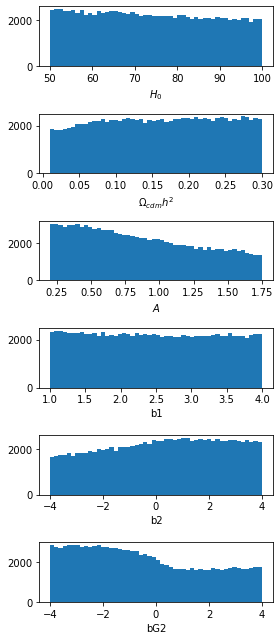

In [18]:
# check that the validation set samples from the entire data range
params = test_data[:][0]
H0 = params[:,0].cpu().detach().numpy()
omch2 = params[:,1].cpu().detach().numpy()
As = params[:,2].cpu().detach().numpy()
b1 = params[:,3].cpu().detach().numpy()
b2 = params[:,4].cpu().detach().numpy()
bG2 = params[:,5].cpu().detach().numpy()

fig, ax = plt.subplots(6, figsize=(4, 9))
ax[0].hist(H0, bins=50);      ax[0].set_xlabel(r"$H_0$")
ax[1].hist(omch2, bins=50); ax[1].set_xlabel(r"$\Omega_{cdm} h^2$")
ax[2].hist(As, bins=50);   ax[2].set_xlabel(r"$A$")
ax[3].hist(b1, bins=50);      ax[3].set_xlabel(r"b1")
ax[4].hist(b2, bins=50);      ax[4].set_xlabel("b2")
ax[5].hist(bG2, bins=50);      ax[5].set_xlabel("bG2")
plt.tight_layout()

The following cell computes the ocvariance matrix at the fiducial cosmology

In [5]:
# This cell computes the covariance matrix at the fiducial cosmology (TODO: move this to a better spot!)
# t1 = time.time()
# params_fid = np.array([67.77,0.1184,1, 1.9485,-0.5387, 0.1, 5, -15, 100., 5e3])
# params_best = np.array([70.848,0.1120,0.7573, 2.8213,-0.2566, -0.0442, 12.0884, 4.54, 381.8, 984])
# params_marg =  np.array([67.77,0.1184,1, 1.9485,-0.5387, 0.1, 0, 0, 500., 0])
# C_G = CovaPT.get_gaussian_covariance(params_marg)
# C_SSC, C_T0 = CovaPT.get_non_gaussian_covariance(params_marg)
# C_fid = C_G + C_SSC + C_T0
# #C_fid = C_G
# t2 = time.time()
# print("Matrix generated in {:0.2f} s".format(t2 - t1))

# print(C_fid.shape)

# try:
#     L = np.linalg.cholesky(C_fid)
#     print("Covariance matrix is positive-definite :)")
# except np.linalg.LinAlgError as err:
#     print("Covariance matrix is NOT positive-definite!")
    
# np.savez("../Data/Cov_Marg.npz", C_G=C_G, C_SSC=C_SSC, C_T0=C_T0)

/home/joeadamo//Research/CovNet/CovaPT.py:188: IntegrationWarning: The maximum number of subdivisions (60) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp = (quad(trispIntegrand, -1, 1,args=(k1,k2,Plin), limit=60)[0]/2. + expr)/i22**2


Matrix generated in 145.76 s
(50, 50)
Covariance matrix is positive-definite :)


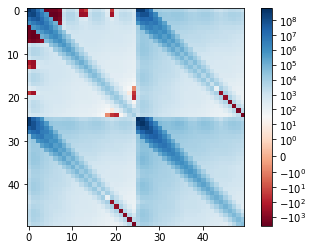

In [6]:
plt.figure()
plt.imshow(C_fid, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_fid), vmax=np.amax(C_fid)))
plt.colorbar()

(96, 96)


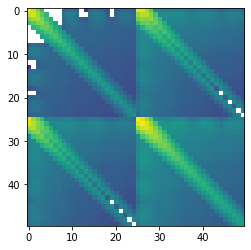

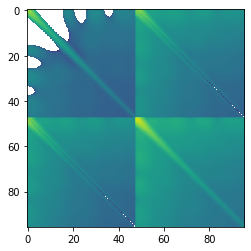

In [37]:
C_montepython = np.loadtxt("/home/joeadamo/Research/lss_montepython/data/ngc_z3/analytic_covmat.dat")
print(C_montepython.shape)

plt.imshow(C_fid, norm=colors.LogNorm(vmin=1e0, vmax=np.amax(C_fid)))

plt.figure()
plt.imshow(C_montepython, norm=colors.LogNorm(vmin=1e0, vmax=np.amax(C_fid)))

### Data pre-processing code  
The following cells exist to test several different pre-processing methods for the covariance matrix

tensor([5.3498e+01, 1.4479e-01, 1.9123e-02, 2.6533e+00, 1.0893e+00, 1.3363e+00,
        2.7070e+00])
966


<Figure size 432x288 with 0 Axes>

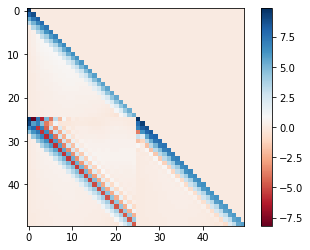

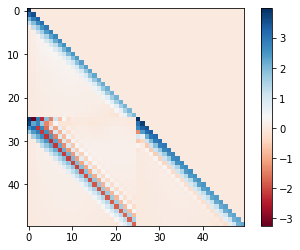

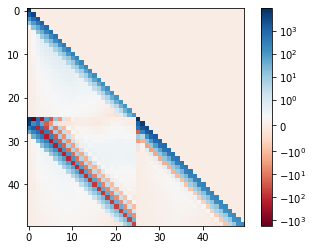

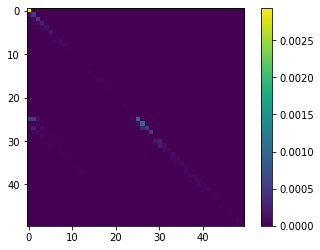

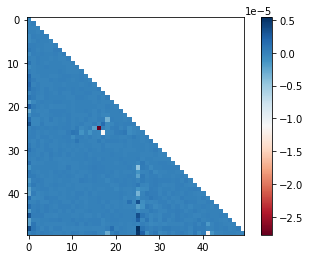

In [13]:
# test the logarithm function and make sure exp(log(C)) = C
idx = np.random.randint(0, N)
C = test_data[idx][1]
params = test_data[idx][0]
print(params)
C_log = CovNet.symmetric_log(C); C_1 = CovNet.symmetric_exp(C_log)
# C and C_1 should be equal, so C - C_1 should just be a matrix of all zeros
idx_bad = np.where(abs((C - C_1) / C) > 1e-14)
print(len(idx_bad[0]))
# plt.imshow(C - C_1, cmap="RdBu")
# cbar = plt.colorbar()

plt.figure()
C_sinh = np.arcsinh(C)
C_2 = np.sinh(C_sinh)
plt.figure()
plt.imshow(C_sinh, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(C_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
m = plt.imshow(C_1, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1.))
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C))
cbar = plt.colorbar()

plt.figure()
plt.imshow((C_1 - C) / C, cmap="RdBu")
cbar = plt.colorbar()

In [14]:
x = torch.linspace(-100, 100, 25, device=CovNet.try_gpu())
x_log = CovNet.symmetric_log(x)
x_1 = CovNet.symmetric_exp(x_log)
print(x)
print(x_log)
print(x_1)
print(x_1 - x)

tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00, -3.8147e-06,  8.3333e+00,  1.6667e+01,
         2.5000e+01,  3.3333e+01,  4.1667e+01,  5.0000e+01,  5.8333e+01,
         6.6667e+01,  7.5000e+01,  8.3333e+01,  9.1667e+01,  1.0000e+02])
tensor([-2.0043e+00, -1.9669e+00, -1.9260e+00, -1.8808e+00, -1.8304e+00,
        -1.7733e+00, -1.7076e+00, -1.6301e+00, -1.5357e+00, -1.4150e+00,
        -1.2472e+00, -9.7004e-01, -1.6567e-06,  9.7004e-01,  1.2472e+00,
         1.4150e+00,  1.5357e+00,  1.6301e+00,  1.7076e+00,  1.7733e+00,
         1.8304e+00,  1.8808e+00,  1.9260e+00,  1.9669e+00,  2.0043e+00])
tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00, -3.8147e-06,  8.3333e+00,  1.6667e+01,
         2.5000e+01,  3.3333e+01,  4.1667e+01,  5

In [15]:
# Convert data in .txt format to .npz format
# training_dir = "/home/joeadamo/Research/Data/Training-Set/"
# new_dir = "/home/joeadamo/Research/Data/Training-Set-New/"
# for idx in range(52500):
    
#     file = training_dir+"CovA-"+f'{idx:05d}'+".txt"
#     f = open(file)
#     header = f.readline()
#     header = f.readline()
#     f.close()
#     header = torch.from_numpy(np.fromstring(header[2:-1], sep=","))
#     params = torch.cat([header[0:4], header[5:]]).detach().numpy()
#     # load in matrix
#     C = np.loadtxt(file, skiprows=2)
#     np.savez(new_dir+"CovA-"+f'{idx:05d}'+".npz", params=params, C=C)
    
#     test = np.load(new_dir+"CovA-"+f'{idx:05d}'+".npz")
#     params_l = test["params"]; C_l = test["C"]
#     assert np.array_equal(params_l, params) and np.array_equal(C, C_l)
# print("Done!")

In [16]:
# Test Cholesky decomposition
train_cholesky = True
idx = np.random.randint(0, N)
C = test_data[idx][1].view(1,100,100)
#C = symmetric_log(C)

if train_cholesky:
    C = torch.linalg.cholesky(C)
B = C.shape[0]
L1 = torch.tril(C)[:,:,:50]; L2 = torch.tril(C)[:,:,50:]
L1 = torch.cat((torch.zeros((B,1, 50), device=CovNet.try_gpu()), L1), 1)
L2 = torch.cat((torch.flip(L2, [1,2]), torch.zeros((B,1, 50), device=try_gpu())),1)
C_half = L1 + L2

C_full = torch.zeros((B, 100,100), device=CovNet.try_gpu())
C_full[:,:,:50] = C_full[:,:,:50] + C_half[:,1:,:]
C_full[:,:,50:] = C_full[:,:,50:] + torch.flip(C_half[:,:-1,:], [1,2])
L = torch.tril(C_full); U = torch.transpose(torch.tril(C_full, diagonal=-1),1,2)
if train_cholesky: # <- undo the cholesky decomposition
    C_full = torch.matmul(L, torch.transpose(L, 1, 2))
else:
    C_full = L + U
    
L = L.view(100,100); C = C.view(100,100); C_half = C_half.view(101,50); C_full = C_full.view(100,100)
chisq_true = chi_squared(C.cpu().detach().numpy(), x)
chisq_pred = chi_squared(C_full.cpu().detach().numpy(), x)
print(chisq_true, chisq_pred)

plt.imshow((symmetric_log(C).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_half).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_full).cpu()), cmap="RdBu")
cbar = plt.colorbar()
# try training the quadrants independently

plt.figure()
plt.imshow(abs(torch.matmul(C, torch.t(C)) - C_full).cpu())
cbar = plt.colorbar()

RuntimeError: shape '[1, 100, 100]' is invalid for input of size 2500

In [ ]:
# test code to convert to / from correlation matrix
idx = np.random.randint(0, N)
print("idx = ", idx)
C = test_data[idx][1].view(1, 100, 100)
D = torch.sqrt(torch.diagonal(C,0,1,2))
D = torch.diag_embed(D)
Corr = torch.matmul(torch.linalg.inv(D), torch.matmul(C, torch.linalg.inv(D)))
Corr = Corr + (CovNet.symmetric_log(D) - torch.eye(100))

plt.figure()
plt.imshow(CovNet.symmetric_log(C).view(100,100), cmap="RdBu")
plt.colorbar()

plt.figure()
plt.imshow(Corr.view(100,100).cpu())
cbar = plt.colorbar()

D_1 = torch.diag_embed(torch.diagonal(Corr,0,1,2))
Corr = Corr - (D_1) + torch.eye(100)
D_1 = CovNet.symmetric_exp(D_1)
C_1 = torch.matmul(D_1, torch.matmul(Corr, D_1))

plt.figure()
plt.imshow(CovNet.symmetric_log(C_1).view(100,100).cpu(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C).view(100,100).cpu())
cbar = plt.colorbar()

In [ ]:
# test code for splitting up matrix into quadrands
idx = np.random.randint(0, int(N*0.1))
print("idx = ", idx)
C = test_data[idx][1].view(1, 100, 100)
quad1 = C[:,:50,:50]
quad2 = C[:,50:,50:]
quad3 = C[:,:50,50:]

C = C.view(100,100); quad1 = quad1.view(50,50); quad2 = quad2.view(50,50); quad3 = quad3.view(50,50)
plt.imshow(C.cpu().detach().numpy(), cmap="RdBu")
plt.colorbar()

print(quad1.shape, quad2.shape, quad3.shape)
plt.figure()
plt.imshow(quad1.cpu().detach().numpy(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(quad2.cpu().detach().numpy(), cmap="RdBu")

plt.figure()
plt.imshow(quad3.cpu().detach().numpy(), cmap="RdBu")

plt.figure()
plt.imshow(abs(quad3 - torch.t(quad3)).cpu().detach().numpy())
cbar = plt.colorbar()

In [ ]:
# If there are any matrices with NaN's or inf's, check them out
print(nans)
if len(nans) != 0:
    params = test_data[nans][0]
    C = test_data[nans][1].view(100,100).detach().numpy()
    print(np.where(np.isnan(C)==True))

    data_bad = np.load(training_dir+"CovNG-30528.npz")
    print(data_bad["C"][98,98])

    print(params)
    plt.imshow(C, cmap="RdBu")
    plt.colorbar()

In [ ]:
# Test Principle component analysis comparison code
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

idx = 100
idx_2 = 101
print("idx = ", idx)
C = test_data[idx][1].view(100, 100).detach().numpy()
C_2 = test_data[idx_2][1].view(100, 100).detach().numpy()

C_normal = C.flatten()
#C_normal = StandardScaler().fit_transform(C)
#C_normal = (C - np.mean(C)) / np.std(C)

pca = PCA(n_components = 2)
#pca.fit(C_normal)
#components = pca.transform(C_normal)

# the eigenvalue way
Cov = np.cov(np.vstack((C_normal, C_normal)), rowvar=False)
print(Cov.shape, Cov)
l, principal_axes = np.linalg.eig(Cov)
# sort
idx = l.argsort()[::-1]
l, principal_axes = l[idx], principal_axes[:, idx]
components_eigen = np.matmul(C_normal, principal_axes)

# the SVD way
U, s, Vt = np.linalg.svd(C_normal)
V = Vt.T
S = np.diag(s)
components_svd = np.matmul(U, S)

print("eigen:", l[0] / np.sum(l), l[1] / np.sum(l))
print("svd:", s[0] / np.sum(s), s[1] / np.sum(s))
#print("sklearn:", pca.explained_variance_ratio_)

#plt.scatter(components[:,0], components[:,1], s=35)
plt.scatter(components_eigen[:,0], components_eigen[:,1], s=25)
plt.scatter(components_svd[:,0], components_svd[:,1], s=15)
#plt.scatter(components_2[:,0], components_2[:,1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")

In [ ]:
#C_2_normal = (C_2 - np.mean(C_2)) / np.std(C_2)
C_2_normal = StandardScaler().fit_transform(C_2)

components_2 = pca.transform(C_2_normal)
components_2_eigen = np.matmul(C_2_normal, principal_axes)
components_2_svd = np.matmul(C_2_normal, V)

sum_1 = np.sum(abs(components_2 - components), axis=0)
sum_2 = np.sum(abs(components_eigen - components_2_eigen), axis=0)
print(sum_1, sum_2)

plt.scatter(components_2[:,0], components_2[:,1], s=35)
plt.scatter(components_2_eigen[:,0], components_2_eigen[:,1], s=25)
plt.scatter(components_2_svd[:,0], components_2_svd[:,1], s=15)

In [ ]:
# import os
# for i in tqdm(range(49500, 50000)):
#     if os.path.exists(training_dir + "CovNG-"+f'{i:05d}'+".npz"):
#         file1 = np.load(training_dir + "CovNG-"+f'{i:05d}'+".npz")
#         #file2 = np.load(training_dir + "CovG-"+f'{i:05d}'+".npz")
#         params = file1["params"]
#         C_NG = file1["C"]
#         C_G = CovaPT.get_gaussian_covariance(params, pgg)
#         np.savez(training_dir + "CovA-"+f'{i:05d}'+".npz", params=params, C_G=C_G, C_NG=C_NG)
#         os.remove(training_dir + "CovNG-"+f'{i:05d}'+".npz")
#         #os.remove(training_dir + "CovG-"+f'{i:05d}'+".npz")

In [ ]:
test_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-HighZ-NGC/"
params = np.zeros((9228, 7))
idx = 0
for i in range(75000):
    filename = test_dir+"CovA-"+f'{i:05d}'+".npz"
    if os.path.exists(filename):
        data = np.load(filename)
        params[idx] = data["params"]
        idx+=1

print(params[0])
        
names = ['H0', 'omch2', 'ombh2', "As", "ns", "b1", "b2"]
from getdist import plots, MCSamples
import getdist
# 3D (scatter) triangle plot
plt.scatter(params[:,0], params[:,1], s=1)
#plt.scatter(params_list[:,1], params_list[:,2], s=1)
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_{cdm} h^2$")
plt.figure()
samples = MCSamples(samples=params ,names = names, labels = names)
g = plots.get_subplot_plotter(width_inch=6)
# you can adjust the scaling factor if font sizes are too small when
# making many subplots in a fixed size (default=2 would give smaller fonts)
g.settings.scaling_factor = 1
g.triangle_plot(samples, ['H0', 'omch2', 'ombh2', "As", "ns", "b1", "b2"], plot_3d_with_param='omch2')